In [ ]:
# default_exp run_sequence_3d

# Actions in video

> API details.

We use pre-trained ResNet50 model, available from [here](https://drive.google.com/drive/folders/1zvl89AgFAApbH0At-gMuZSeQB_LpNP-M)

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import os
import time
import datetime
from tqdm.notebook import tqdm
import pathlib

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable

from actions_in_videos.avi import AVI
from torch.utils.data import Dataset, DataLoader
from pdb import *

from actions_in_videos.data_augmentation import *
from actions_in_videos.dataset_ucf101 import UCF101, SequenceDataset, DataLoader, SequenceBatchShower, ARSequenceDataset
from actions_in_videos.models_resnet_3d import ResNet50_3D, resnet50
from actions_in_videos.models import ResNet50ClassifierOneFrame

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

In [ ]:
print('torch.__version__', torch.__version__)

torch.__version__ 1.3.0


In [ ]:
save_dir = pathlib.Path('model-checkpoints')
save_dir.mkdir(parents=True, exist_ok=True)

pretrained_dir = pathlib.Path('model-pretrained')
pretrained_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
opt = {
    'num-classes': 101,
    'channels':3,
    'img-size':224,
    'sequence-length': 1,
    'sample-interval': 1,
    'dataset-path': '../data/UCF101/',
    'batch-size': 32,
    'learning-rate': 0.0001,
    'num-epochs': 10,
    'checkpoint_interval': 1,
    'checkpoint-model': pretrained_dir/'resnet-50-kinetics.pth',
    'smaller-dataset': False
      }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_shape = (opt['channels'], opt['img-size'], opt['img-size'])

# Normalization parameters for pre-trained PyTorch models
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

# Sequence (Kinetic dataset)
mean = np.asarray([0.433, 0.4045, 0.3776],np.float32)
std = np.asarray([0.1519876, 0.14855877, 0.156976],np.float32)



## Create the Training set and its associated Dataloader:

Define the transformations:

If we want to use the torchvision transformations:

In [ ]:
train_tsfms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop((224, 224)),
        transforms.Resize((opt['img-size'], opt['img-size']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])

Or if instead I want to use my own

In [ ]:
# train_tsfms = transforms.Compose(
#             [
#                 ImageRandomCrop(out_ratio=0.7, p_crop=0.5),
#                 ImageRandomHorizontalFlip(p_flip=0.5),
#                 ImageRescale((opt['img-size'], opt['img-size'])),
#                 ImageAddRandomBrightness(),                               
#                 ImageNormalize(),
#                 ImageToTensor()
#             ])

I now define a single frame sequence

In [ ]:
#export
class OneFrameSequenceDataset(Dataset):
    """Sequence based dataset for the UCF101.
    
    Output is of shape:
        seq_len, H, W, C
        
    Note that when this is passed onto a DataLoader with toTensor() transform, it changes its shape to:
        batch_size, seq_length, C, H, W 
        
    """

    def __init__(self, dataset_path, training=True, transform=None, safe=True, verbose=False, smaller_dataset=False):
        """
        Args:            
            file_list: list of files as a numpy array.
            labels: one entry per filename in the list of files as a numpy array.
            train: flag to say whether train or test dataset is used.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sequence_length = 1
        self.sample_interval = 1
        self.training = training
        self.safe = safe # impacts the getSequence method of the AVI class accessed through getRandomSequence method.
        self.verbose = verbose

        ucf = UCF101(dataset_path)
        
        X, class_names = ucf.getFileList(data_type='train' if training else 'test', smaller_dataset=smaller_dataset)
        self.file_list, self.labels = X[0], X[1]
        self.class_names = class_names
        self.num_classes = len(self.class_names)
        self.transform = transform
        self._debug = False
        self.lastfile_loaded = None
    
    def setVerbose(self, flag=False):
        self.verbose=flag
    
    def debug(self, flag=False, seq_idx=0, seq_len=6):
        self._debug = flag
        self._debug_seq_idx = seq_idx
        self._debug_seq_len = seq_len
        
    def getClassName(self, idx):
        return self.class_names[idx]
    
    def getFileName(self, idx):
        return self.file_list[idx]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        """
        Args:
        - idx: item index
        returns: 
        - sequence: list of frames of length self.sequence_length
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #video_list = self.file_list[idx]
        video_list = self.file_list[idx % len(self)] # wraps up if an out of index idx is used.
        avi = AVI(video_list, verbose=self.verbose, safe=self.safe)  # setting verbose to True might help debugging.
    
        # saves last files open
        
        # frames is a numpy matrix of shape seq_len, H, W, C
        if self._debug:
            # WARNING: THIS IS ONLY FOR DEBUGGING PURPOSES. SHOULD BE REMOVED LATER.
            # print(f'video_list: {video_list}')
            # self.lastfile_loaded = video_list
            #         print("avi._attributes['n-frames']-idx_0:", avi._attributes['n-frames']-idx_0)
            #idx_0 = avi._attributes['n-frames']-2
#             frames = avi.getSequence(idx_0=idx_0, seq_len=avi._attributes['n-frames']-idx_0, sample_interval=1, circular=False)  
            idx_0 = self._debug_seq_idx
            frames = avi.getSequence(idx_0=idx_0, seq_len=self._debug_seq_len, sample_interval=1, circular=False)  
        else:
            frames = avi.getRandomSequence(self.sequence_length, self.sample_interval)
                     
        label = self.labels[idx]
        label = np.array([label])
                
        # Extract frames as tensors
        image_sequence = []
        
        if self.transform:
            sequence = None 
            for i, frame in enumerate(frames):             
                frame = self.transform(frame)  # here frame might be a tensor
                if sequence is None:           
                    # we still need to allocate it.
                    sequence = np.zeros(np.array(np.append(np.array([self.sequence_length]), np.array(frame.shape))))
                sequence[i,:,:,:] = frame
            frames = sequence
 
        return frames, label
#        return frames.squeeze(), label
            

And get the data:

In [ ]:
# Define training set
train_ds = OneFrameSequenceDataset(
    dataset_path=opt['dataset-path'],
    training=True,
    smaller_dataset=False,
    transform=train_tsfms
)
train_dl = DataLoader(train_ds, batch_size=opt['batch-size'], shuffle=True, num_workers=0)

Number of training files: 9537


## ILLINOIS COURSE

Use the thing on the course:

In [ ]:
# train_ds = ARSequenceDataset(dataset_path='../data/UCF101/', 
#                            sequence_length=16, 
#                            training=True, 
#                            transform=None, 
#                            verbose=True, 
#                            smaller_dataset=opt['smaller-dataset'])

# print(f"Num of classes: {train_ds.num_classes}")

# train_dl = DataLoader(dataset=train_ds, batch_size=opt['batch-size'], shuffle=True, num_workers=4)

Number of training files: 9537
Num of classes: 101


## Let's make sure that we are loading the correct stuff:

batch-size: 32 fig-size:10, max_batch_len: 4, max_seq_len: 6
batch sample size: torch.Size([32, 1, 3, 224, 224])
[['Rafting'], ['CricketShot'], ['JumpingJack'], ['CleanAndJerk']]


<Figure size 720x720 with 0 Axes>

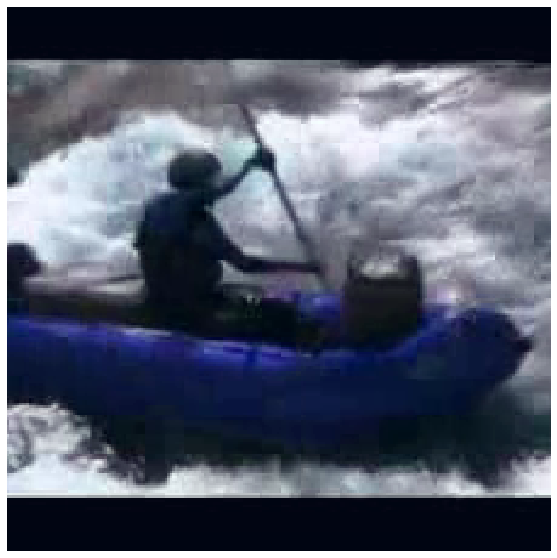

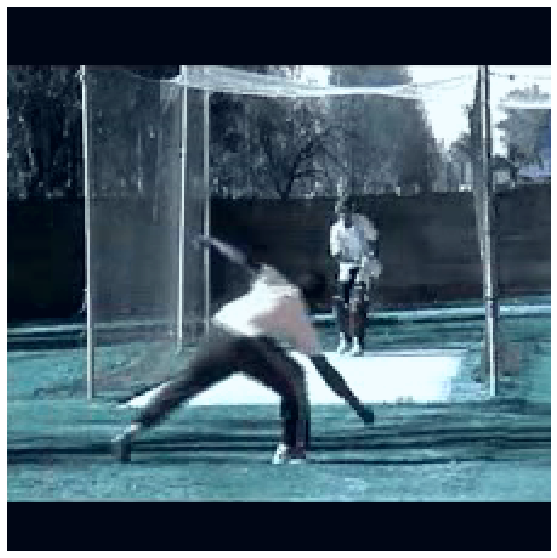

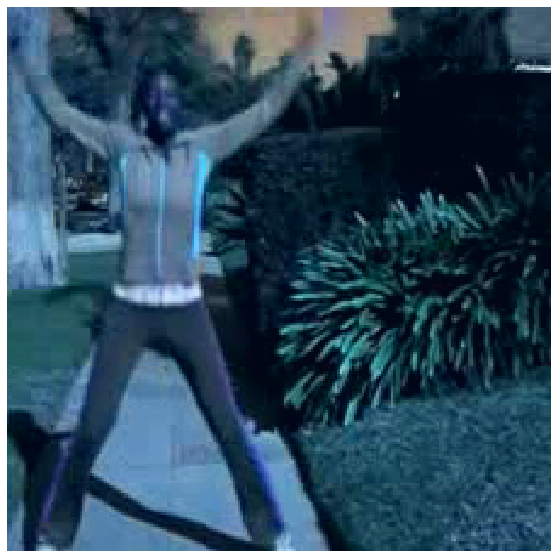

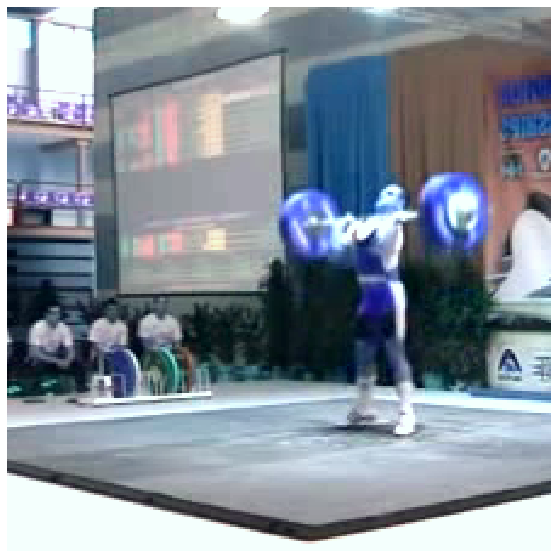

In [ ]:
sb = SequenceBatchShower(train_dl, fig_size=10, max_batch_len=4, max_seq_len=6)
print(sb)

sb.showBatch(3, scale=255, permuteToImg=(0,2,3,1)) # for OneFrameSequenceDataset
#sb.showBatch(3, scale=255, permuteToImg=(1,2,3,0)) # for ARSequenceDataset

# Define test set

Using torchvision transformations

In [ ]:
test_tsfms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((opt['img-size'], opt['img-size']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])

Or using mine:

In [ ]:
# test_tsfms = transforms.Compose([ImageRescale((opt['img-size'], opt['img-size'])),
#                                  ImageNormalize(),
#                                  ImageToTensor()])

In [ ]:
# test_ds = SequenceDataset(
#     dataset_path=opt['dataset-path'],
#     sequence_length=opt['sequence-length'],
#     sample_interval=opt['sample-interval'],
#     training=False,
#     smaller_dataset=True,
#     transform=test_tsfms
# )


# test_dl = DataLoader(test_ds, batch_size=opt['batch-size'], shuffle=False, num_workers=4)

In [ ]:
# test_ds = ARSequenceDataset(dataset_path='../data/UCF101/', 
#                            sequence_length=16, 
#                            training=False, 
#                            transform=None, 
#                            verbose=True, 
#                            smaller_dataset=opt['smaller-dataset'])

# print(f"Num of classes: {test_ds.num_classes}")

# test_dl = DataLoader(test_ds, batch_size=opt['batch-size'], shuffle=False, num_workers=4)

Number of validation files: 114
Num of classes: 3


In [ ]:
test_ds = OneFrameSequenceDataset(
    dataset_path=opt['dataset-path'],
    training=False,
    smaller_dataset=False,
    transform=test_tsfms
)


test_dl = DataLoader(test_ds, batch_size=opt['batch-size'], shuffle=False, num_workers=4)

Number of validation files: 3783


We can see what it contains. Note that in this case, there is no randomness so most likely all frames will be from the same video.

batch-size: 32 fig-size:10, max_batch_len: 1, max_seq_len: 16
batch sample size: torch.Size([32, 1, 3, 224, 224])
[['ApplyLipstick']]


<Figure size 720x720 with 0 Axes>

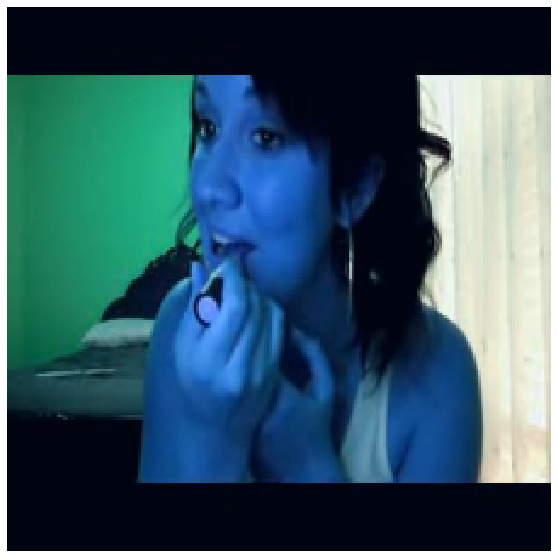

In [ ]:
sb = SequenceBatchShower(test_dl, fig_size=10, max_batch_len=1, max_seq_len=16)
print(sb)

sb.showBatch(2, scale=255, permuteToImg=(0,2,3,1))  # OneFrameSequence
#sb.showBatch(2, scale=255, permuteToImg=(1,2,3,0)) # AR

# Define the model

### MINE

In [ ]:
# # Define network
# model = ResNet50_3D(num_classes=101,
#                     model_pretrained=opt['checkpoint-model'],
#                     sample_size=opt['img-size'], 
#                     sample_duration=opt['sequence-length'])

Freeze the parameters of the parts we do not want to train and set to true those of the last few layers that we are interested in updating.

The dataset is not large enough to warrant training a full ResNet-50 model. 

To start, we will just fine-tune the output layer and the last BottleNeck block (or residual block). `model.layer4` contains three residual blocks implying model.layer4[2] is the last of these three residual blocks. Fine-tuning only the top layers also reduces the amount of GPU memory, meaning a higher batch size can be used and the model can be trained more quickly with less overfitting.

In [ ]:
# for param in model.parameters():
#     param.requires_grad_(False)

# for param in model.feature_extractor.layer4[0].parameters():
#     param.requires_grad_(True)
# for param in model.feature_extractor.fc.parameters():
#     param.requires_grad_(True)

# params = []
# for param in model.feature_extractor.layer4[0].parameters():
#     params.append(param)
# for param in model.feature_extractor.fc.parameters():
#     params.append(param)

# len(params)

## Using a single frame classifier:

In [ ]:
# Define network
model = ResNet50ClassifierOneFrame(
    num_classes=train_ds.num_classes
)

### ORIGINAL

In [ ]:
!ls ./model-pretrained/resnet-50-kinetics.pth

./model-pretrained/resnet-50-kinetics.pth


In [ ]:
model =  resnet50(sample_size=224, sample_duration=16)
pretrained = torch.load('./model-pretrained/resnet-50-kinetics.pth')

keys = [k for k,v in pretrained['state_dict'].items()]
pretrained_state_dict = {k[7:]: v.cpu() for k, v in pretrained['state_dict'].items()}
model.load_state_dict(pretrained_state_dict)
model.fc = nn.Linear(model.fc.weight.shape[1], 101)

function resnet50


Set params to optimize

In [ ]:
model

ResNet50ClassifierOneFrame(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
for param in model.parameters():
    param.requires_grad_(False)
for param in model.feature_extractor[7][2].parameters():
    param.requires_grad_(True)
for param in model.final.parameters():
    param.requires_grad_(True)
params = []
for param in model.feature_extractor[7][2].parameters():
    params.append(param)
for param in model.final.parameters():
    params.append(param)

If using a ResNet3d

In [ ]:
# for param in model.parameters():
#     param.requires_grad_(False)

# # for param in model.conv1.parameters():
# #     param.requires_grad_(True)
# # for param in model.bn1.parameters():
# #     param.requires_grad_(True)
# # for param in model.layer1.parameters():
# #     param.requires_grad_(True)
# # for param in model.layer2.parameters():
# #     param.requires_grad_(True)
# # for param in model.layer3.parameters():
# #     param.requires_grad_(True)
# for param in model.layer4[0].parameters():
#     param.requires_grad_(True)
# for param in model.fc.parameters():
#     param.requires_grad_(True)

# params = []
# # for param in model.conv1.parameters():
# #     params.append(param)
# # for param in model.bn1.parameters():
# #     params.append(param)
# # for param in model.layer1.parameters():
# #     params.append(param)
# # for param in model.layer2.parameters():
# #     params.append(param)
# # for param in model.layer3.parameters():
# #     params.append(param)
# for param in model.layer4[0].parameters():
#     params.append(param)
# for param in model.fc.parameters():
#     params.append(param)



In [ ]:
len(params)

11

### RESUME WORKFLOW

In [ ]:
#model

In [ ]:
# Classification criterion
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(params, lr=opt['learning-rate'])

In [ ]:
# if opt['checkpoint-model']:
#     print(f"Loading checkpoint model: opt['checkpoint-model']")
#     model.load_state_dict(torch.load(opt['checkpoint-model']))

## Training

We have now everything we need to build the training loop. This is done in the next two functions, the first one is to test the model on the validation set and the second one is the actual training loop.

In [ ]:
def test_model(model,epoch):
    """ Evaluate the model on the test set """
    print("")
    model.eval()
    test_metrics = {"loss": [], "acc": []}
        
    for batch_i, (X, y) in enumerate(tqdm(test_dl, 'Test', leave=False)): 
        
        # dataload outputs size: [batch_size, seq_len, c, h, w]
        # we need the input x to be size [batch_size, c, seq_len, h, w].
        #X = X.permute(0,2,1,3,4) 
                
        image_sequences = Variable(X.to(device), requires_grad=False).float()
        labels = Variable(y.to(device), requires_grad=False)
            
        labels = labels.squeeze()
        if len(labels.size()) == 0:
            labels = torch.tensor([labels]).to(device)
        
        with torch.no_grad():
            # Get sequence predictions
            preds = model(image_sequences)

##################################################
#         with torch.no_grad():
#             h = model.conv1(image_sequences)
#             h = model.bn1(h)
#             h = model.relu(h)
#             h = model.maxpool(h)

#             h = model.layer1(h)
#             h = model.layer2(h)
#             h = model.layer3(h)
#             h = model.layer4[0](h)
#             # h = model.layer4[1](h)

#             h = model.avgpool(h)

#             h = h.view(h.size(0), -1)
#             preds = model.fc(h)
##################################################

                    
        # Compute metrics
        acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()
        loss = criterion(preds, labels).item()
        
        # Keep track of loss and accuracy
        test_metrics["loss"].append(loss)
        test_metrics["acc"].append(acc)
        
        # Log test performance
        sys.stdout.write(
            "\r    Testing | Batch %d/%d | Loss: %f (%f), Acc: %.2f%% (%.2f%%) | "
            % (
                batch_i,
                len(test_dl),
                np.mean(test_metrics["loss"]),
                loss,
                np.mean(test_metrics["acc"]),
                acc,                
            )
        )    
    print("")

In [ ]:
def train_model(model, opt, train_dl, test_dl):

    assert 'checkpoint-model' in opt.keys(), "Specify path to checkpoint model or set it to False"
    
    for epoch in tqdm(range(opt['num-epochs']), desc='Epoch #'):
        epoch_metrics = {"loss": [], "acc": []}
        prev_time = time.time()

        #print(f"--- Epoch {epoch} ---")
        for batch_i, (X, y) in enumerate(tqdm(train_dl, 'Train', leave=False)):
            model.train()

            #print(X.shape)
            #[32, 3, 16, 224, 224]
            # dataload outputs size: [batch_size, seq_len, c, h, w]
            # we need the input x to be size [batch_size, c, seq_len, h, w].
            # X = X.permute(0,2,1,3,4)            
        
            if X.size(0) == 1:
                continue

            image_sequences = Variable(X.to(device), requires_grad=False).float()
            labels = Variable(y.to(device), requires_grad=False)
                        
            labels = labels.squeeze()
            if len(labels.size()) == 0:
                labels = torch.tensor([labels]).to(device)

            # forward
            optimizer.zero_grad()            
            with torch.set_grad_enabled(True):
                # Get sequence predictions
                preds = model(image_sequences)

                # Compute metrics   
                loss = criterion(preds, labels)
                acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()

                loss.backward()
                optimizer.step()


######################################################
#             with torch.no_grad():
#                 h = model.conv1(image_sequences)
#                 h = model.bn1(h)
#                 h = model.relu(h)
#                 h = model.maxpool(h)

#                 h = model.layer1(h)
#                 h = model.layer2(h)
#                 h = model.layer3(h)
#             h = model.layer4[0](h)

#             h = model.avgpool(h)

#             h = h.view(h.size(0), -1)
#             preds = model.fc(h)

#             loss = criterion(preds, labels)
#             optimizer.zero_grad()

#             loss.backward()
#             optimizer.step()
            
#             acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()
######################################################            

            # Keep track of epoch metrics
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)

            # Determine approximate time left
            batches_done = epoch * len(train_dl) + batch_i
            batches_left = opt['num-epochs'] * len(train_dl) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\rEpoch %d/%d | Batch %d/%d | Loss: %f (%f), Acc: %.2f%% (%.2f%%) | ETA: %s"
                % (
                    epoch,
                    opt['num-epochs'],
                    batch_i,
                    len(train_dl),
                    np.mean(epoch_metrics["loss"]),
                    loss.item(),
                    np.mean(epoch_metrics["acc"]),                    
                    acc,
                    time_left,
                )
            )

#             Empty cache
#             if torch.cuda.is_available():
#                  torch.cuda.empty_cache()

        # Evaluate the model on the test set
        test_model(model, epoch)

        model.train()
        
        # Save model checkpoint
        if epoch % opt['checkpoint_interval'] == 0:
            os.makedirs('model-checkpoints', exist_ok=True)
            checkpoint_mdl_name = f"model-checkpoints/{model.__class__.__name__}_{epoch}.pth"
            print(f"Epoch {epoch}: Model saved as: {checkpoint_mdl_name}")
            torch.save(model.state_dict(), checkpoint_mdl_name)
            
    # Print log
    print("-------------------------------------------------------")
    sys.stdout.write(
        "\rEpoch %d/%d | Batch %d/%d | Loss: %f (%f), Acc: %.2f%% (%.2f%%) | ETA: %s"
        % (
            epoch+1,
            opt['num-epochs'],
            batch_i,
            len(train_dl),
            np.mean(epoch_metrics["loss"]),
            loss.item(),            
            np.mean(epoch_metrics["acc"]),
            acc,
            time_left,
        )
    )
    
    # save last model
    os.makedirs('model-checkpoints', exist_ok=True)
    random_int = int(np.random.uniform(0,1e14))
    final_model_name = f"model-checkpoints/{model.__class__.__name__}_{epoch}_{random_int}.pth"
    torch.save(model.state_dict(), final_model_name)
    print(f"\nModel saved as: {final_model_name}")
    
    return model

In [ ]:
model = train_model(model, opt, train_dl, test_dl)

Epoch 0/10 | Batch 64/299 | Loss: 4.292963 (3.896795), Acc: 12.16% (21.88%) | ETA: 5:57:52.553616

In [ ]:
model = train_model(model, opt, train_dl, test_dl)

Epoch 0/10 | Batch 8/9 | Loss: 3.880487 (2.975533), Acc: 78.12% (100.00%) | ETA: 0:00:43.553859


    Testing | Batch 3/4 | Loss: 3.785483 (3.977326), Acc: 82.47% (61.11%) | 
Epoch 0: Model saved as: model-checkpoints/ResNet_0.pth


Epoch 1/10 | Batch 8/9 | Loss: 2.238418 (1.808725), Acc: 99.31% (100.00%) | ETA: 0:00:38.6905726


    Testing | Batch 3/4 | Loss: 2.944719 (3.454538), Acc: 80.47% (50.00%) | 
Epoch 1: Model saved as: model-checkpoints/ResNet_1.pth


Epoch 2/10 | Batch 8/9 | Loss: 1.442226 (1.092001), Acc: 98.96% (100.00%) | ETA: 0:00:34.0681769


    Testing | Batch 3/4 | Loss: 2.476697 (3.253626), Acc: 76.30% (33.33%) | 
Epoch 2: Model saved as: model-checkpoints/ResNet_2.pth


Epoch 3/10 | Batch 8/9 | Loss: 1.022828 (0.989187), Acc: 99.31% (100.00%) | ETA: 0:00:29.3333717


    Testing | Batch 3/4 | Loss: 2.032723 (2.950848), Acc: 80.03% (38.89%) | | 
Epoch 3: Model saved as: model-checkpoints/ResNet_3.pth


Epoch 4/10 | Batch 8/9 | Loss: 0.662175 (0.582713), Acc: 99.65% (100.00%) | ETA: 0:00:24.490603


    Testing | Batch 3/4 | Loss: 1.600601 (2.516241), Acc: 82.38% (38.89%) | | 
Epoch 4: Model saved as: model-checkpoints/ResNet_4.pth


Epoch 5/10 | Batch 8/9 | Loss: 0.456033 (0.445318), Acc: 100.00% (100.00%) | ETA: 0:00:19.636755


    Testing | Batch 3/4 | Loss: 1.224133 (2.092774), Acc: 87.33% (55.56%) | | 
Epoch 5: Model saved as: model-checkpoints/ResNet_5.pth


Epoch 6/10 | Batch 8/9 | Loss: 0.346864 (0.407452), Acc: 100.00% (100.00%) | ETA: 0:00:14.882050


    Testing | Batch 3/4 | Loss: 0.929303 (1.705010), Acc: 90.89% (66.67%) | | 
Epoch 6: Model saved as: model-checkpoints/ResNet_6.pth


Epoch 7/10 | Batch 8/9 | Loss: 0.247901 (0.239232), Acc: 100.00% (100.00%) | ETA: 0:00:10.138791


    Testing | Batch 3/4 | Loss: 0.726588 (1.357336), Acc: 90.89% (66.67%) | | 
Epoch 7: Model saved as: model-checkpoints/ResNet_7.pth


Epoch 8/10 | Batch 8/9 | Loss: 0.194498 (0.183092), Acc: 100.00% (100.00%) | ETA: 0:00:05.322824


    Testing | Batch 3/4 | Loss: 0.571434 (0.975264), Acc: 95.05% (83.33%) | | 
Epoch 8: Model saved as: model-checkpoints/ResNet_8.pth


Epoch 9/10 | Batch 8/9 | Loss: 0.161396 (0.184054), Acc: 100.00% (100.00%) | ETA: 0:00:00.533035


    Testing | Batch 3/4 | Loss: 0.515840 (0.927593), Acc: 94.27% (83.33%) | | 
Epoch 9: Model saved as: model-checkpoints/ResNet_9.pth

-------------------------------------------------------
Epoch 10/10 | Batch 8/9 | Loss: 0.161396 (0.184054), Acc: 100.00% (100.00%) | ETA: 0:00:00.533035
Model saved as: model-checkpoints/ResNet_9_18887568768972.pth


In [ ]:
test_model(model, 1)

In [ ]:
train_model(model, opt, train_dl, test_dl)

In [ ]:
# [batch_size,3,16,224,224].

In [ ]:
from nbdev.export import *
notebook2script()

In [ ]:
!ls ../number-five/notebooks/3d_resnet1.model

In [ ]:
model =  resnet50(sample_size=224, sample_duration=16)
model.fc = nn.Linear(model.fc.weight.shape[1], 101)
model.load_state_dict(torch.load('../number-five/notebooks/3d_resnet1.model_dict'))

In [ ]:
model.cuda()
test_model(model, 2)